This is currently under construction.

This notebook contains the functions that are called inside the rubix pipeline.

# Config

contains all the information needed to run the pipeline. Those are run specfic configurations.

In [1]:
import os
config = {
    "logger": {
        "log_level": "DEBUG",
        "log_file_path": None,
        "format": "%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    },
    "data": {
        "name": "IllustrisAPI",
        "args": {
            "api_key": os.environ.get("ILLUSTRIS_API_KEY"),
            "particle_type": ["stars"],
            "simulation": "TNG50-1",
            "snapshot": 99,
            "save_data_path": "data",
        },
        
        "load_galaxy_args": {
        "id": 14,
        "reuse": True,
        }
    },
    "simulation": {
        "name": "IllustrisTNG",
        "args": {
            "path": "data/galaxy-id-14.hdf5",
        },
    
    },
    "output_path": "output",

    "telescope":
        {"name": "MUSE"},
        
    "cosmology":
        {"name": "PLANCK15"},
        
    "galaxy":
        {"dist_z": 0.1}

        
}

In [2]:
from rubix.core.data import convert_to_rubix, prepare_input

convert_to_rubix(config) # Convert the config to rubix format and store in output_path folder
coords, vel, metallicity, mass, age = prepare_input(config) # Prepare the input for the pipeline

2024-05-04 18:33:33,098 - rubix - INFO - Rubix galaxy file already exists, skipping conversion


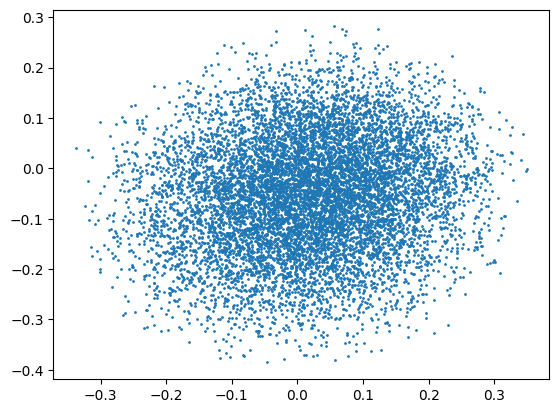

In [3]:
import matplotlib.pyplot as plt
# Make a scatter plot 
n_subset = 10000
subset = coords[:n_subset]

plt.scatter(subset[:,0], subset[:,1], s=1)


Load a telescope


In [4]:
from rubix.core.telescope import get_telescope, get_spaxel_assignment

telescope = get_telescope(config)
telescope

/home/ufuk/Dokumente/Research/Masterarbeit/rubix/rubix/telescope/factory.py:20: UserWarning: No telescope config provided, using default stored in /home/ufuk/Dokumente/Research/Masterarbeit/rubix/rubix/telescope/telescopes.yaml
  warnings.warn(


MUSE(
  fov=5,
  spatial_res=0.2,
  wave_range=[4700.15, 9351.4],
  wave_res=1.25,
  lsf_fwhm=2.51,
  signal_to_noise=None,
  wave_centre=6975.775,
  sbin=25,
  aperture_region=f32[625],
  pixel_type='square'
)

Get the function that does the binning

In [5]:
from rubix.core.cosmology import get_cosmology
from rubix.telescope.utils import calculate_spatial_bin_edges, square_spaxel_assignment
cosmo = get_cosmology(config)
galaxy_dist = config["galaxy"]["dist_z"]

edges, size = calculate_spatial_bin_edges(fov = telescope.fov, spatial_bins=telescope.sbin, dist_z=galaxy_dist, cosmology=cosmo)
print(edges, size)
print(edges.shape)

[-4.7619     -4.380948   -3.9999962  -3.6190443  -3.2380924  -2.8571405
 -2.4761887  -2.0952368  -1.7142849  -1.333333   -0.95238113 -0.57142925
 -0.19047737  0.19047451  0.5714264   0.9523783   1.3333302   1.714282
  2.095234    2.4761858   2.8571377   3.2380896   3.6190414   3.9999933
  4.380945  ] 0.380952
(25,)


In [6]:
bin_particles = get_spaxel_assignment(config)

/home/ufuk/Dokumente/Research/Masterarbeit/rubix/rubix/telescope/factory.py:20: UserWarning: No telescope config provided, using default stored in /home/ufuk/Dokumente/Research/Masterarbeit/rubix/rubix/telescope/telescopes.yaml
  warnings.warn(


In [7]:
# Make a scatter plot of the spaxels
spaxel_index = bin_particles(coords)

print("Shape of spaxel_index", spaxel_index.shape)

Shape of spaxel_index (484076,)


Array([300, 300, 300, ..., 552, 575, 575], dtype=int32)

In [18]:
import jax 
import jax.numpy as jnp
import numpy as np



sbin = telescope.sbin
# Calculate the number of particles per spaxel


# Calculate the number of particles per spaxel
num_particles = jax.ops.segment_sum(jnp.ones_like(coords[:, 0]), spaxel_index, num_segments=sbin**2)

# Create the image
image = np.zeros(sbin**2)

image[spaxel_index] = num_particles



# Reshape and log scale the image
image = image.reshape(sbin, sbin)
image = jnp.log10(image + 1)

# Display the image
plt.imshow(image, origin="lower")
plt.show()

ValueError: shape mismatch: value array of shape (625,) could not be broadcast to indexing result of shape (484076,)

In [20]:
num_particles.shape

(625,)